In [250]:
import os,sys
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from  pyspark.sql.types import *

In [2]:
names = "Timestamp FLOW_indicator Agent_address Input_port \
    Output_port Src_MAC Dst_MAC Ethernet_type In_vlan Out_vlan \
    Src_ip Dst_ip Ip_protocol Ip_tos Ip_ttl Udp_src_port_OR_tcp_src_port_OR_icmp_type \
    Udp_dst_port_OR_tcp_dst_port_OR_icmp_code \
    Tcp_flags Packet_size IP_size Sampling_rate".split()
fields = ["StringType()"]*len(names)
schema = StructType([StructField(field_name,eval(field_type), True) for field_name, field_type in zip(names,fields)])

In [3]:
df = spark.read.csv("/home/kommiu/Downloads/slow-sample.csv/sflow-0118.csv",schema = schema)

In [4]:
src = df.select(df["Src_ip"].alias("ip"), df["Packet_size"].cast(IntegerType()))
dst = df.select(df["Dst_ip"].alias("ip"), df["Packet_size"].cast(IntegerType()))
data = src.union(dst)
data.cache()

DataFrame[ip: string, Packet_size: int]

In [166]:
byIP = data.groupBy('ip').agg(sum('Packet_size').alias('sum'))
byIP.cache()
byIP.write.json(os.path.join(sys.path[0],'byIP_sampled'), mode='overwrite')

In [6]:
def get_country(ip):
    from geoip2.database import Reader
    from geoip2.errors import AddressNotFoundError
    try:
        reader = Reader("./GeoLite2-Country.mmdb")
        response = reader.country(ip)
        country = response.country.name
        return  country if country else "NOT_FOUND"
    except AddressNotFoundError:
        return "NOT_FOUND"
udf_get_country = udf(get_country,StringType())

In [7]:
withCountry = byIP.withColumn('country',udf_get_country(col('ip')))
withCountry.cache()

DataFrame[ip: string, sum: bigint, country: string]

In [8]:
byCountry = withCountry.groupBy('country').agg(sum('sum').alias('sum'))
byCountry.cache()
byCountry.coalesce(1).write.json(os.path.join(sys.path[0],'byCountry_sampled'),mode='overwrite')

In [14]:
byCountry_pd = byCountry.sort('sum').toPandas()


<Container object of 194 artists>

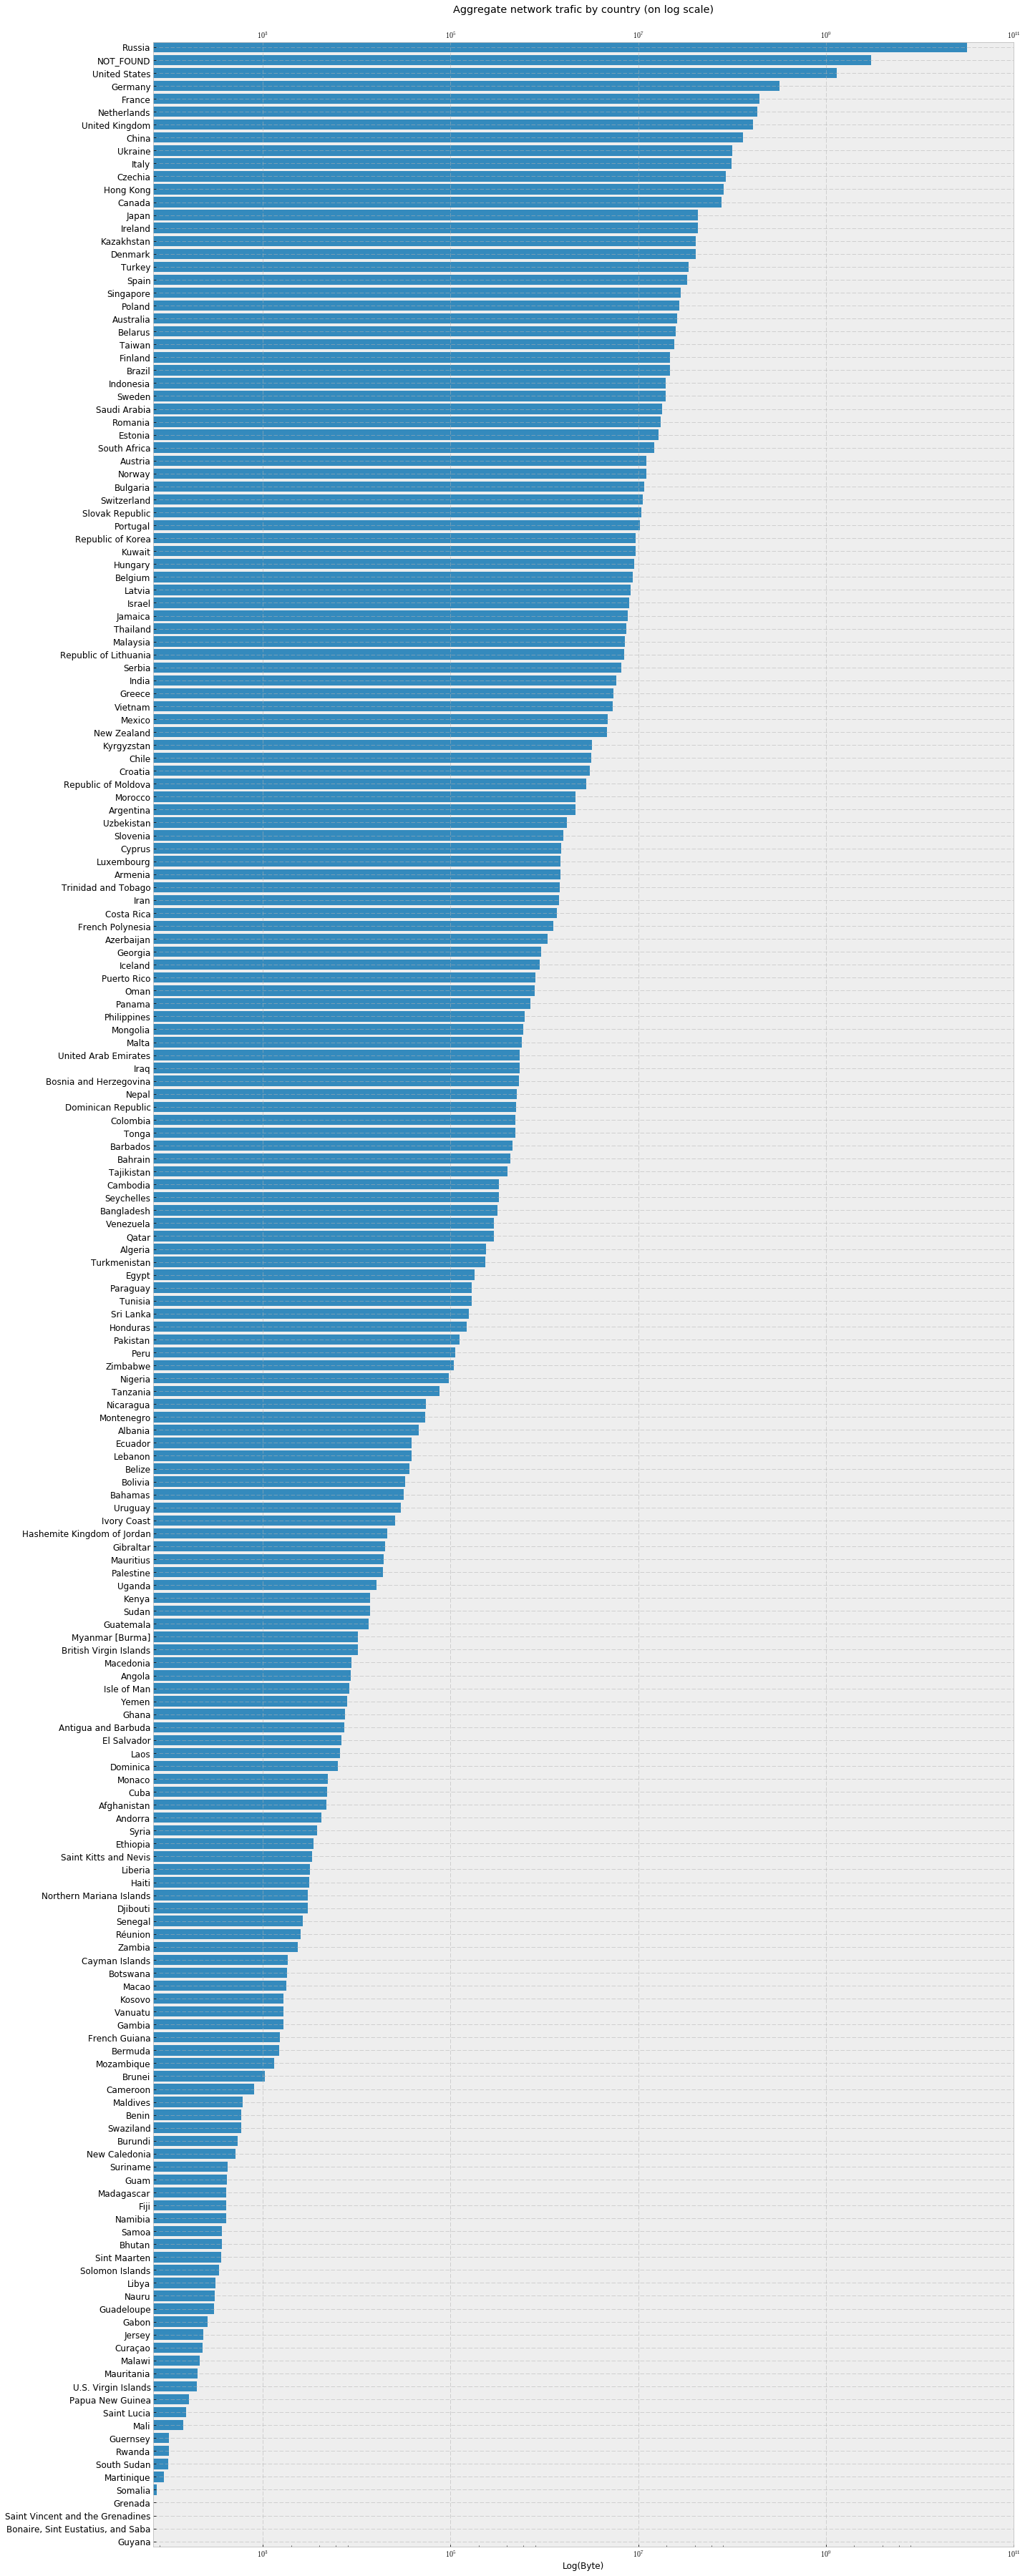

In [145]:
index = range(byCountry_pd.shape[0])
fig,ax = plt.subplots(figsize=(20,50))
ax.barh(index, byCountry_pd['sum'])
ax.set_xscale('log')
ax.set_xlabel('Log(Byte)')
ax.set_title('Aggregate network trafic by country (on log scale)',y=1.01)
ax.margins(0,0)
ax.set_xlim(0,1e11)
ax.tick_params(labeltop='on')
plt.yticks(index, byCountry_pd['country'], rotation='horizontal',fontsize=12)
fig.tight_layout()
plt.show()
fig.savefig('vertical_plot.png')
plt.close(fig)

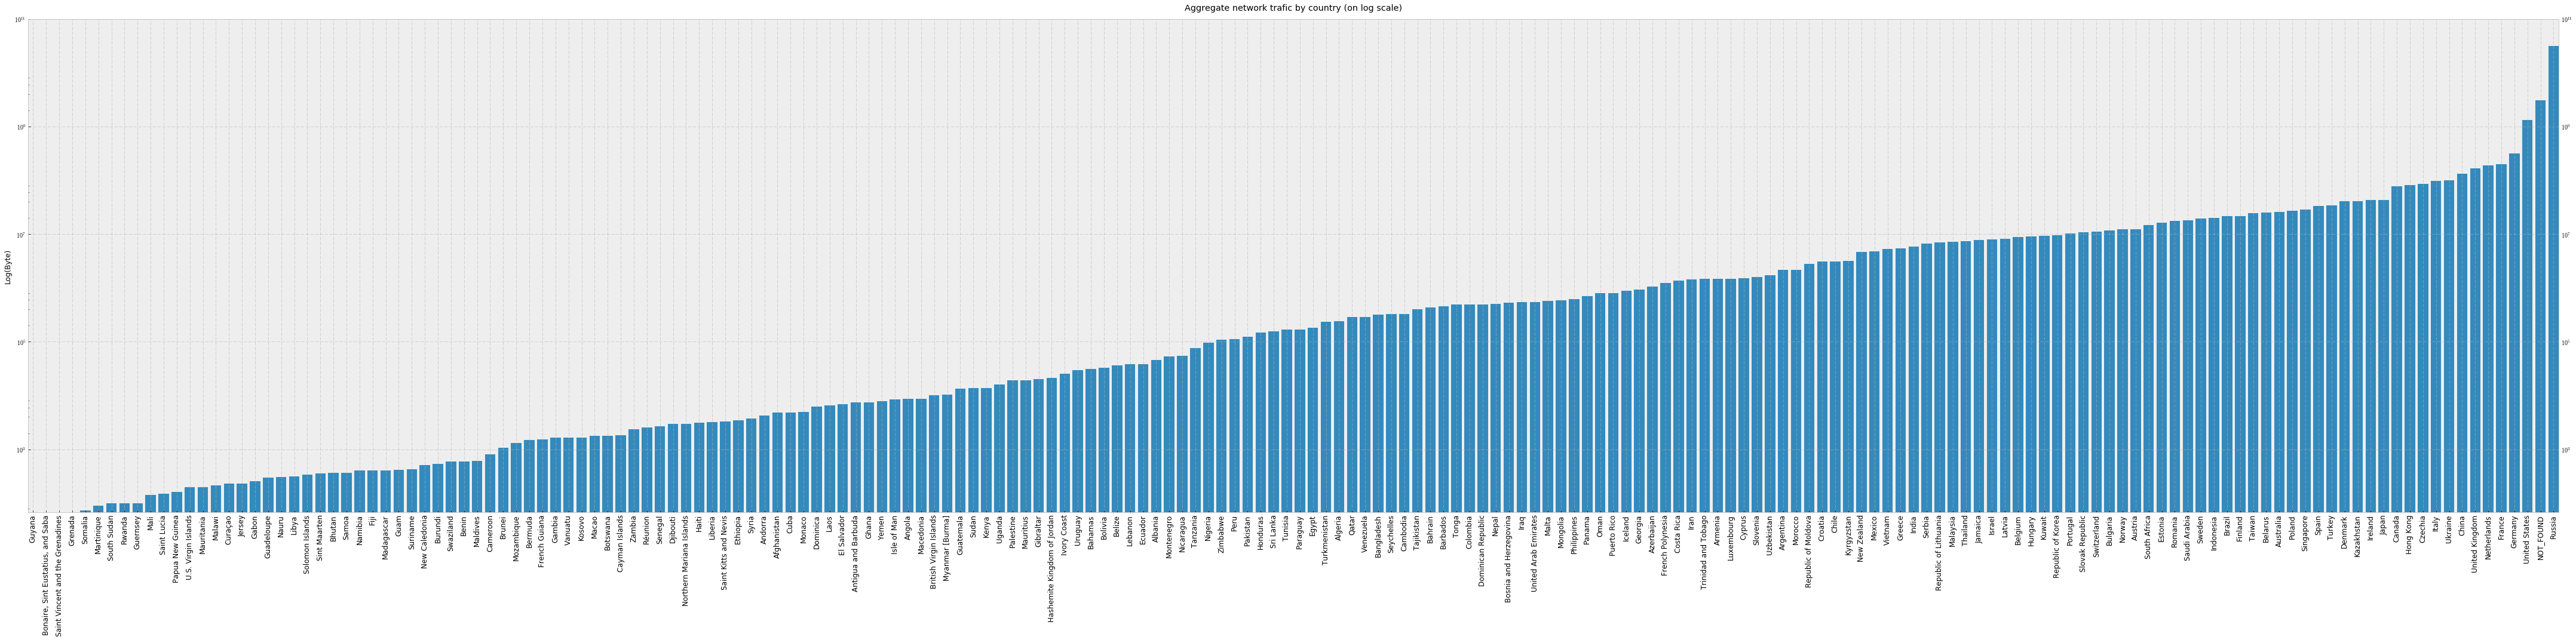

In [151]:
fig,ax = plt.subplots(figsize=(60,15))
ax.bar(index, byCountry_pd['sum'])
ax.set_yscale('log')
ax.set_ylabel('Log(Byte)')
ax.set_title('Aggregate network trafic by country (on log scale)',y=1.01)
ax.margins(0,0)
ax.set_ylim(0,1e11)
ax.tick_params(labelright='on')
plt.xticks(index, byCountry_pd['country'], rotation='vertical',fontsize=12)
fig.tight_layout()
plt.show()
fig.savefig('horizontal_plot.png')
plt.close(fig)

## 4. Дополнительный бонус 1
Изучить sFlow и объяснить почему подсчет трафика, вычисляемый как указано выше, не является корректным, реализовать в задании корректный вариант: http://www.sflow.org/packetSamplingBasics/index.htm

Поскольку представленный датасет содержит только случайную выборку из всего трафика за рассматриваемый период, то посчитанные выше распределения трафика(по адресам и странам) не являются корректными.

Чтобы получить оценку трафика за весь период используем форумулу (18) из приведенной в задании статьи: $B_c=\bar{b_c}N_c$, с учетом формул (19) и (12) получим $B_c=\bar{b_c}N_c=\frac{\sum{b_{ci}}}{c}*\frac{c*N}{n}=\sum{b_{ci}}*sampling\_rate$,
Вычислим так же дисперсию нашей оценки, опуская элементарные преобразования, получим из формул (22), (20), (19), (12), (13) следующее выражение:
$var(B_c) = $

$\frac{1}{2}$

In [167]:
n = sc.broadcast(data.count())
sr = sc.broadcast(512)


In [153]:
df.select("Sampling_rate").distinct().collect()

[Row(Sampling_rate='512')]

In [245]:
test = data.groupBy('ip').agg(sum(col('Packet_size')).alias('sum'), sum(col('Packet_size')**2).alias('sumSq'),\
        count('ip').alias('count')).withColumn('Vbm',(col('count')*col('sumSq')-col('sum')**2)\
        /(col('count')*(col('count')-1)))\
        .withColumn('VN',((sr.value**2)*col('count')*(n.value-col('count')))/(n.value-1))\
        .withColumn('VB',col('Vbm')*col('VN')+col('VN')*(col('sum')/col('count'))**2+col('Vbm')*(col('count')*512)**2)
        
test.cache()

DataFrame[ip: string, sum: bigint, sumSq: double, count: bigint, Vbm: double, VN: double, VB: double]

In [233]:
from math import sqrt

In [238]:
c = 3593
print(c*512)
print(1.96*512*sqrt(c))
print(512**2*c)

1839616
60152.632849337526
941883392


In [251]:
test.withColumn('sigma',sqrt(col('VB'))).withColumn("B",(512*col('sum'))).select('ip','B','sigma').show()

+---------------+---------+--------------------+
|             ip|        B|               sigma|
+---------------+---------+--------------------+
|123.183.208.215|300890112| 4.026703978811721E8|
| 217.23.186.191|  2341888|  2016535.8071992134|
|176.209.199.233|393388544| 2.699416281844732E8|
| 37.150.200.150|    34816|                null|
|    46.35.249.4|    34816|                null|
|  176.14.226.58| 24267776|1.9722141709933084E7|
|  173.197.32.34| 31240704|3.1694168089671977E7|
|173.196.178.251|   317440|  131338.86350596687|
| 194.54.152.230|  2222080|  1901610.9812123908|
|   141.8.142.41|460485632|5.2422622492332774E8|
|   217.9.156.60|  8090624|   7962742.516233337|
|194.126.217.130|   759808|  457538.27573014534|
| 78.139.222.212|  4369920|  5397498.8830832625|
|   83.149.46.15|  2384896|   2993836.166366611|
|   31.211.119.8| 14868992| 1.022379437830296E7|
| 83.246.141.174|  3256320|  3567379.4187237923|
|  79.136.156.27| 13633536|1.3445008349602088E7|
|193.106.133.186|   

In [221]:
test.cache()

DataFrame[ip: string, sum: bigint, sumSq: double, count: bigint]

In [181]:
'''
byIP_fixed = data.withColumn('Packet_size',col('Packet_size')/1024).groupBy('ip').agg(sum('Packet_size').alias('sum')\
            ,count('ip').alias('count'),sum(col('Packet_size')**2)\
            .alias('sum_of_squared')).withColumn('squared_sum',col('sum')**2)\
            .withColumn('Var(Nc)',sr.value**2*col('count')*(n.value-col('count'))/(n.value*(n.value-1)))\
            .withColumn('Var(bmean)',(col('sum_of_squared')*col('count')-col('squared_sum'))/(col('count')*(col('count')-1)))\
            .withColumn('Var(B)',col('Var(bmean)')*col('Var(Nc)')+(sr.value*col('count'))**2*col('Var(bmean)')\
            +(col('sum')/col('count'))**2*col('Var(Nc)'))\
            .withColumn('sigma',sqrt(col('Var(B)')))
'''

+---------------+-----------+
|             ip|Packet_size|
+---------------+-----------+
|  91.221.61.253|        154|
|  91.221.61.158|        126|
| 176.120.24.151|       1522|
|   192.168.30.2|         68|
|   91.221.61.35|         83|
|  91.221.61.117|         68|
|   91.221.61.35|        162|
|   91.221.61.35|        146|
|   192.168.30.2|        162|
|   82.200.77.35|       1522|
| 90.188.117.209|       1510|
|    78.140.8.74|        103|
| 176.120.24.142|        244|
|  95.170.159.78|        170|
|205.234.140.231|       1522|
|   176.120.26.5|       1522|
| 90.188.114.166|       1510|
|  176.65.63.190|       1522|
|   82.200.77.35|       1522|
| 176.120.24.154|       1522|
| 176.120.24.151|       1522|
| 176.120.24.154|       1522|
| 176.120.25.186|       1522|
|  91.221.61.168|         68|
|  91.221.61.168|        110|
|   176.120.26.5|       1522|
| 176.120.25.128|         74|
| 176.120.24.142|         74|
| 149.154.167.80|       1302|
|   83.172.27.18|       1522|
+---------

In [226]:
n.value

45574522

In [249]:
del sqrt